In [40]:
# specify your outputs diretory 
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"
raw_data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
temp_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/temp"

# Necessary Packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm

# dataset 
data = pd.read_csv(f"{output_dir}/data/historical_data_feb.csv")
data['date'] = pd.to_datetime(data['date']) 
    
# oil price data 
oil_data = pd.read_csv(f"{raw_data_dir}/oil_data/oil_price_shock.csv")
oil_data = oil_data.rename(columns={'observation_date':'date', 
                                   'WTISPLC_PC1':'oil_price_change'})
oil_data['date'] = pd.to_datetime(oil_data['date'])


# monetary policy shock data 
monetary_shock = pd.read_csv(f"{raw_data_dir}/monetary_policy_shock/shock_data.csv")

In [41]:
monetary_shock['date'] = pd.to_datetime(monetary_shock[['Year', 'Month']].assign(DAY=1))

In [42]:
df = data.merge(oil_data, on=['date'])
df = df.merge(monetary_shock, on = ['date'])

In [43]:
def format_2col_latex_table(models, row_labels, model_labels):
    latex = "\\begin{table}[!htbp]\n\\centering\n"
    latex += "\\caption{Effect of Inflation on V/U Residuals}\n"
    latex += "\\label{tab:vu_iv}\n"
    latex += "\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{l" + "c" * len(models) + "}\n"
    latex += "\\toprule\n"
    latex += " & " + " & ".join(model_labels) + " \\\\\n"
    latex += "\\midrule\n"

    for var in row_labels:
        row = row_labels[var] + " & "
        for model in models:
            if var in model.params:
                coef = model.params[var]
                se = model.bse[var]
                stars = ""
                p = model.pvalues[var]
                if p < 0.01:
                    stars = "^{***}"
                elif p < 0.05:
                    stars = "^{**}"
                elif p < 0.1:
                    stars = "^{*}"
                row += f"${coef:.3f}{stars}$ ({se:.3f}) & "
            else:
                row += " & "
        latex += row.rstrip("& ") + "\\\\\n"

    latex += "\\midrule\n"
    r2_row = "R$^2$ & " + " & ".join(f"{m.rsquared:.3f}" for m in models) + " \\\\\n"
    n_row = "Observations & " + " & ".join(f"{int(m.nobs)}" for m in models) + " \\\\\n"
    latex += r2_row
    latex += n_row
    latex += "\\bottomrule\n\\end{tabular}%\n}\n"
    latex += "\\caption*{\\footnotesize Standard errors in parentheses. $^{***}p<0.01$, $^{**}p<0.05$, $^{*}p<0.1$}\n"
    latex += "\\end{table}"
    return latex


In [48]:
import pandas as pd
import statsmodels.api as sm


# Define time periods
periods = [
    ('1950-01-01', '2019-12-01'),
    ('1950-01-01', '2024-12-01')
]

# Store results
all_models = []
model_labels = []

for start_date, end_date in periods:
    # Filter data
    reg_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()
    reg_data['U_rate_squared'] = reg_data['U_rate'] ** 2

    # Residualize 1‑month inflation ~ unemployment
    subset_infl = reg_data[['U_rate', 'U_rate_squared', 'P_1m_change']].dropna()
    X_infl = sm.add_constant(subset_infl[['U_rate', 'U_rate_squared']])
    y_infl = subset_infl['P_1m_change']
    infl_model = sm.OLS(y_infl, X_infl).fit()
    reg_data.loc[subset_infl.index, 'inflation_residuals'] = infl_model.resid

    # Residualize V/U (tightness) ~ unemployment
    subset_vu = reg_data[['U_rate', 'U_rate_squared', 'tightness']].dropna()
    X_vu = sm.add_constant(subset_vu[['U_rate', 'U_rate_squared']])
    y_vu = subset_vu['tightness']
    vu_model = sm.OLS(y_vu, X_vu).fit()
    reg_data.loc[subset_vu.index, 'vu_residuals'] = vu_model.resid

    # IV data: use MPS as instrument
    iv_data = reg_data[['inflation_residuals', 'vu_residuals', 'MPS']].dropna()

    # First stage: inflation_residuals ~ MPS
    X_first_stage = sm.add_constant(iv_data[['MPS']])
    y_first_stage = iv_data['inflation_residuals']
    first_stage = sm.OLS(y_first_stage, X_first_stage).fit(cov_type='HC1')
    iv_data['predicted_inflation'] = first_stage.fittedvalues

    # Second stage: vu_residuals ~ predicted_inflation
    X_second_stage = sm.add_constant(iv_data['predicted_inflation'])
    y_second_stage = iv_data['vu_residuals']
    second_stage = sm.OLS(y_second_stage, X_second_stage).fit(cov_type='HC1')

    # OLS (non-instrumented)
    X_ols = sm.add_constant(iv_data['inflation_residuals'])
    ols_model = sm.OLS(iv_data['vu_residuals'], X_ols).fit(cov_type='HC1')

    # Store models and labels
    all_models.extend([ols_model, second_stage])
    model_labels.extend([
        f"OLS ({start_date[:4]}–{end_date[:4]})",
        f"IV ({start_date[:4]}–{end_date[:4]})"
    ])

# Format table for LaTeX
row_labels = {
    'const': 'Constant',
    'inflation_residuals': 'Inflation Residual',
    'predicted_inflation': 'Instrumented Inflation Residual'
}

latex_output = format_2col_latex_table(all_models, row_labels, model_labels)
print(latex_output)


\begin{table}[!htbp]
\centering
\caption{Effect of Inflation on V/U Residuals}
\label{tab:vu_iv}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccc}
\toprule
 & OLS (1950–2019) & IV (1950–2019) & OLS (1950–2024) & IV (1950–2024) \\
\midrule
Constant & $0.000$ (0.005) & $0.000$ (0.005) & $0.000$ (0.009) & $0.000$ (0.009)\\
Inflation Residual & $0.016$ (0.019) &  & $0.213^{***}$ (0.053)\\
Instrumented Inflation Residual &  & $0.627^{***}$ (0.226) &  & $0.715^{***}$ (0.217)\\
\midrule
R$^2$ & 0.002 & 0.023 & 0.087 & 0.023 \\
Observations & 383 & 383 & 431 & 431 \\
\bottomrule
\end{tabular}%
}
\caption*{\footnotesize Standard errors in parentheses. $^{***}p<0.01$, $^{**}p<0.05$, $^{*}p<0.1$}
\end{table}


In [39]:
# 1. Create lead of next month's P_1m_change
df['P1m_lead'] = df['P_1m_change'].shift(-1)

# 2. Drop rows with missing values
df_clean = df.dropna(subset=['P1m_lead', "P_1m_change", "P_4m_change", "P_12m_change", 'MPS'])

# 3. Prepare regressors and response
X = sm.add_constant(df_clean['MPS'])  # add intercept
y = df_clean["P_1m_change"]

# 4. Fit OLS with robust (HC1) standard errors
model = sm.OLS(y, X).fit()

# 5. Print the regression summary (includes F-stat, t-stats, etc.)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            P_1m_change   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     10.20
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00151
Time:                        15:20:06   Log-Likelihood:                -45.806
No. Observations:                 430   AIC:                             95.61
Df Residuals:                     428   BIC:                             103.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2276      0.013     17.493      0.0

In [4]:
df.to_csv(f"{temp_dir}/long_time_series.csv")

In [6]:
def format_2col_latex_table(models, row_labels, model_labels):
    latex = "\\begin{table}[!htbp]\n\\centering\n"
    latex += "\\caption{Effect of Inflation on V/U Residuals}\n"
    latex += "\\label{tab:vu_iv}\n"
    latex += "\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{l" + "c" * len(models) + "}\n"
    latex += "\\toprule\n"
    latex += " & " + " & ".join(model_labels) + " \\\\\n"
    latex += "\\midrule\n"

    for var in row_labels:
        row = row_labels[var] + " & "
        for model in models:
            if var in model.params:
                coef = model.params[var]
                se = model.bse[var]
                stars = ""
                p = model.pvalues[var]
                if p < 0.01:
                    stars = "^{***}"
                elif p < 0.05:
                    stars = "^{**}"
                elif p < 0.1:
                    stars = "^{*}"
                row += f"${coef:.3f}{stars}$ ({se:.3f}) & "
            else:
                row += " & "
        latex += row.rstrip("& ") + "\\\\\n"

    latex += "\\midrule\n"
    r2_row = "R$^2$ & " + " & ".join(f"{m.rsquared:.3f}" for m in models) + " \\\\\n"
    n_row = "Observations & " + " & ".join(f"{int(m.nobs)}" for m in models) + " \\\\\n"
    latex += r2_row
    latex += n_row
    latex += "\\bottomrule\n\\end{tabular}%\n}\n"
    latex += "\\caption*{\\footnotesize Standard errors in parentheses. $^{***}p<0.01$, $^{**}p<0.05$, $^{*}p<0.1$}\n"
    latex += "\\end{table}"
    return latex


In [7]:
# Define time periods
periods = [
    ('1950-01-01', '1989-12-01'),
    ('1950-01-01', '2019-12-01'),
    ('1950-01-01', '2024-12-01')
]

# Store results
all_models = []
model_labels = []

for start_date, end_date in periods:
    # Filter data
    reg_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()
    reg_data['U_rate_squared'] = reg_data['U_rate'] ** 2

    # Residualize inflation ~ unemployment
    subset_infl = reg_data[['U_rate', 'U_rate_squared', 'P_12m_change']].dropna()
    X_infl = sm.add_constant(subset_infl[['U_rate', 'U_rate_squared']])
    y_infl = subset_infl['P_12m_change']
    infl_model = sm.OLS(y_infl, X_infl).fit()
    reg_data.loc[subset_infl.index, 'inflation_residuals'] = infl_model.resid

    # Residualize V/U (tightness) ~ unemployment
    subset_vu = reg_data[['U_rate', 'U_rate_squared', 'tightness']].dropna()
    X_vu = sm.add_constant(subset_vu[['U_rate', 'U_rate_squared']])
    y_vu = subset_vu['tightness']
    vu_model = sm.OLS(y_vu, X_vu).fit()
    reg_data.loc[subset_vu.index, 'vu_residuals'] = vu_model.resid

    # IV data
    iv_data = reg_data[['inflation_residuals', 'vu_residuals', 'oil_price_change']].dropna()

    # First stage
    X_first_stage = sm.add_constant(iv_data[['oil_price_change']])
    y_first_stage = iv_data['inflation_residuals']
    first_stage = sm.OLS(y_first_stage, X_first_stage).fit()
    iv_data['predicted_inflation'] = first_stage.fittedvalues

    # Second stage
    X_second_stage = sm.add_constant(iv_data['predicted_inflation'])
    y_second_stage = iv_data['vu_residuals']
    second_stage = sm.OLS(y_second_stage, X_second_stage).fit()

    # OLS (non-instrumented)
    X_ols = sm.add_constant(iv_data['inflation_residuals'])
    ols_model = sm.OLS(iv_data['vu_residuals'], X_ols).fit()

    # Store models and labels
    all_models.extend([ols_model, second_stage])
    model_labels.extend([
        f"OLS ({start_date[:4]}–{end_date[:4]})",
        f"IV ({start_date[:4]}–{end_date[:4]})"
    ])

# Format table
row_labels = {
    'const': 'Constant',
    'inflation_residuals': 'Inflation Residual',
    'predicted_inflation': 'Instrumented Inflation Residual'
}

latex_output = format_2col_latex_table(all_models, row_labels, model_labels)
latex_output


'\\begin{table}[!htbp]\n\\centering\n\\caption{Effect of Inflation on V/U Residuals}\n\\label{tab:vu_iv}\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{lcccccc}\n\\toprule\n & OLS (1950–1989) & IV (1950–1989) & OLS (1950–2019) & IV (1950–2019) & OLS (1950–2024) & IV (1950–2024) \\\\\n\\midrule\nConstant & $0.000$ (0.006) & $0.000$ (0.007) & $0.000$ (0.004) & $0.000$ (0.005) & $0.000$ (0.005) & $0.000$ (0.006)\\\\\nInflation Residual & $0.028^{***}$ (0.002) &  & $0.027^{***}$ (0.001) &  & $0.035^{***}$ (0.002)\\\\\nInstrumented Inflation Residual &  & $0.015^{***}$ (0.004) &  & $0.007^{**}$ (0.004) &  & $0.021^{***}$ (0.005)\\\\\n\\midrule\nR$^2$ & 0.318 & 0.030 & 0.290 & 0.005 & 0.272 & 0.024 \\\\\nObservations & 467 & 467 & 827 & 827 & 887 & 887 \\\\\n\\bottomrule\n\\end{tabular}%\n}\n\\caption*{\\footnotesize Standard errors in parentheses. $^{***}p<0.01$, $^{**}p<0.05$, $^{*}p<0.1$}\n\\end{table}'

In [33]:
# Repeat the analysis using log(V/U) instead of levels
all_models_log = []
model_labels_log = []

for start_date, end_date in periods:
    # Filter data
    reg_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()
    reg_data['U_rate_squared'] = reg_data['U_rate'] ** 2

    # Residualize inflation ~ unemployment
    subset_infl = reg_data[['U_rate', 'U_rate_squared', 'P_12m_change']].dropna()
    X_infl = sm.add_constant(subset_infl[['U_rate', 'U_rate_squared']])
    y_infl = subset_infl['P_12m_change']
    infl_model = sm.OLS(y_infl, X_infl).fit()
    reg_data.loc[subset_infl.index, 'inflation_residuals'] = infl_model.resid

    # Residualize log tightness (ln_tightness) ~ unemployment
    subset_vu = reg_data[['U_rate', 'U_rate_squared', 'ln_tightness']].dropna()
    X_vu = sm.add_constant(subset_vu[['U_rate', 'U_rate_squared']])
    y_vu = subset_vu['ln_tightness']
    vu_model = sm.OLS(y_vu, X_vu).fit()
    reg_data.loc[subset_vu.index, 'vu_residuals_log'] = vu_model.resid

    # IV data
    iv_data = reg_data[['inflation_residuals', 'vu_residuals_log', 'oil_price_change']].dropna()

    # First stage
    X_first_stage = sm.add_constant(iv_data[['oil_price_change']])
    y_first_stage = iv_data['inflation_residuals']
    first_stage = sm.OLS(y_first_stage, X_first_stage).fit()
    iv_data['predicted_inflation'] = first_stage.fittedvalues

    # Second stage
    X_second_stage = sm.add_constant(iv_data['predicted_inflation'])
    y_second_stage = iv_data['vu_residuals_log']
    second_stage = sm.OLS(y_second_stage, X_second_stage).fit()

    # OLS (non-instrumented)
    X_ols = sm.add_constant(iv_data['inflation_residuals'])
    ols_model = sm.OLS(iv_data['vu_residuals_log'], X_ols).fit()

    # Store models and labels
    all_models_log.extend([ols_model, second_stage])
    model_labels_log.extend([
        f"OLS ({start_date[:4]}–{end_date[:4]})",
        f"IV ({start_date[:4]}–{end_date[:4]})"
    ])

# Generate LaTeX table for log(V/U)
latex_output_log = format_2col_latex_table(all_models_log, row_labels, model_labels_log)
latex_output_log


'\\begin{table}[!htbp]\n\\centering\n\\caption{Effect of Inflation on V/U Residuals}\n\\label{tab:vu_iv}\n\\begin{tabular}{lcc}\n\\hline\\hline\n & (1) & (2) \\\\\n & OLS (1950–1989) & IV (1950–1989) \\\\\n\\hline\nConstant & $0.000$ & $0.000$ & $0.000$ & $0.000$ & $0.000$ & $0.000$ \\\\\n & (0.009) & (0.011) & (0.006) & (0.008) & (0.007) & (0.008) \\\\\nInflation Residual & $0.043^{***}$ &  & $0.047^{***}$ &  & $0.049^{***}$ &  \\\\\n & (0.003) &  & (0.002) &  & (0.002) &  \\\\\nInstrumented Inflation Residual &  & $0.024^{***}$ &  & $0.015^{***}$ &  & $0.027^{***}$ \\\\\n &  & (0.006) &  & (0.006) &  & (0.006) \\\\\n\\hline\nR$^2$ & 0.328 & 0.034 & 0.334 & 0.008 & 0.316 & 0.022 \\\\\nObservations & 467 & 467 & 827 & 827 & 887 & 887 \\\\\n\\hline\\hline\n\\multicolumn{3}{l}{\\footnotesize Standard errors in parentheses.}\\\\\n\\multicolumn{3}{l}{\\footnotesize $^{***}$ p$<$0.01, $^{**}$ p$<$0.05, $^{*}$ p$<$0.1}\\\\\n\\end{tabular}\n\\end{table}'

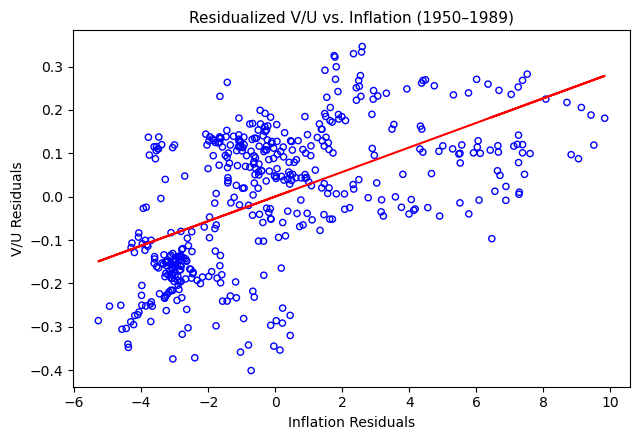

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Prepare data
start_date, end_date = '1950-01-01', '1989-12-01'
reg_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()
reg_data['U_rate_squared'] = reg_data['U_rate'] ** 2

# Residualize inflation ~ unemployment
subset_infl = reg_data[['U_rate', 'U_rate_squared', 'P_12m_change']].dropna()
X_infl = sm.add_constant(subset_infl[['U_rate', 'U_rate_squared']])
y_infl = subset_infl['P_12m_change']
infl_model = sm.OLS(y_infl, X_infl).fit()
reg_data.loc[subset_infl.index, 'inflation_residuals'] = infl_model.resid

# Residualize tightness ~ unemployment
subset_vu = reg_data[['U_rate', 'U_rate_squared', 'tightness']].dropna()
X_vu = sm.add_constant(subset_vu[['U_rate', 'U_rate_squared']])
y_vu = subset_vu['tightness']
vu_model = sm.OLS(y_vu, X_vu).fit()
reg_data.loc[subset_vu.index, 'vu_residuals'] = vu_model.resid

# Merge and plot
plot_data = reg_data[['inflation_residuals', 'vu_residuals']].dropna()
x = plot_data['inflation_residuals']
y = plot_data['vu_residuals']
slope, intercept = np.polyfit(x, y, 1)
plot_data['predicted_vu'] = slope * x + intercept

plt.figure(figsize=(6.5, 4.5))
plt.scatter(x, y, edgecolors='blue', facecolors='none', s=20)
plt.plot(x, slope * x + intercept, color='red', linewidth=1.5)
plt.title('Residualized V/U vs. Inflation (1950–1989)', fontsize=11)
plt.xlabel('Inflation Residuals')
plt.ylabel('V/U Residuals')
plt.tight_layout()
plt.savefig(f"{output_dir}/figures/vu_vs_inflation_residuals_1950_1989.pdf")

plt.show()
plot_data.to_csv(f"{output_dir}/data/vu_inflation_residuals_1950_1989.csv", index=False)
